In [9]:
%pip install pandas
%pip uninstall -y psycopg2
%pip install psycopg2
%pip uninstall -y psycopg2-binary
%pip install psycopg2-binary
%pip install seaborn
%pip install numpy


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Found existing installation: psycopg2 2.9.9
Uninstalling psycopg2-2.9.9:
  Successfully uninstalled psycopg2-2.9.9
Note: you may need to restart the kernel to use updated packages.
  Using cached psycopg2-2.9.9.tar.gz (384 kB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: psycopg2 is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for psycopg2 ... done

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the ker

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import psycopg2
import seaborn as sns
import numpy as np

In [11]:
# Return: correlation coefficient
# For a given month in a given region, queries the database to calcualte the correlation coefficient
def query_without_threshold(cursor, region, month):
    
    cursor.execute('''SELECT SUM(temperature) FROM deaths_and_temperature WHERE month = %s AND region = %s;''', (month, region))
    x_sum = cursor.fetchone()[0]

    cursor.execute('''SELECT SUM(totaldeaths) FROM deaths_and_temperature WHERE month = %s AND region = %s;''', (month, region))
    y_sum = cursor.fetchone()[0]

    cursor.execute('''SELECT SUM(temperature * temperature) FROM deaths_and_temperature WHERE month = %s AND region = %s;''', (month, region))
    x_squared_sum = cursor.fetchone()[0]

    cursor.execute('''SELECT SUM(totaldeaths * totaldeaths) FROM deaths_and_temperature WHERE month = %s AND region = %s;''', (month, region))
    y_squared_sum = cursor.fetchone()[0]

    cursor.execute('''SELECT COUNT(*) FROM deaths_and_temperature WHERE month = %s AND region = %s;''', (month, region))
    count_x = cursor.fetchone()[0]

    cursor.execute('''SELECT SUM(temperature * totaldeaths) FROM deaths_and_temperature WHERE month = %s AND region = %s;''', (month, region))
    sum_xy_product = cursor.fetchone()[0]
   
    # math function for the correlation
    try:
        correlation_coefficient = (count_x * sum_xy_product - (x_sum * y_sum)) / math.sqrt((count_x * x_squared_sum - x_sum * x_sum) * (count_x * y_squared_sum - y_sum * y_sum))
    # if denominator is zero, error occurs
    except ZeroDivisionError:
        print("Error: Division by zero. This could be due to the dataset being too small or no data points meeting the threshold.")
        correlation_coefficient = None
    
    return correlation_coefficient

In [12]:
# Return: correlation coefficient
# For a given month in a given region, queries the database to calcualte the correlation coefficient for a spesific threshold for the temperature
def query_with_threshold(cursor, region, month, threshold):
    
    cursor.execute('''SELECT SUM(temperature) FROM deaths_and_temperature WHERE month = %s AND region = %s AND temperature >= %s;''', (month, region, threshold))
    x_sum = cursor.fetchone()[0]
    
    # If datapoint is less than threshold, return None
    if x_sum is None:
        return None
    
    cursor.execute('''SELECT SUM(totaldeaths) FROM deaths_and_temperature WHERE month = %s AND region = %s AND temperature >= %s;''', (month, region, threshold))
    y_sum = cursor.fetchone()[0]
    
    cursor.execute('''SELECT SUM(temperature * temperature) FROM deaths_and_temperature WHERE month = %s AND region = %s AND temperature >= %s;''', (month, region, threshold))
    x_squared_sum = cursor.fetchone()[0]

    cursor.execute('''SELECT SUM(totaldeaths * totaldeaths) FROM deaths_and_temperature WHERE month = %s AND region = %s AND temperature >= %s;''', (month, region, threshold))
    y_squared_sum = cursor.fetchone()[0]

    cursor.execute('''SELECT COUNT(*) FROM deaths_and_temperature WHERE month = %s AND region = %s AND temperature >= %s;''', (month, region, threshold))
    count_x = cursor.fetchone()[0]

    cursor.execute('''SELECT SUM(temperature * totaldeaths) FROM deaths_and_temperature WHERE month = %s AND region = %s AND temperature >= %s;''', (month, region, threshold))
    sum_xy_product = cursor.fetchone()[0]

    # math function for the correlation
    try:
        correlation_coefficient = (count_x * sum_xy_product - (x_sum * y_sum)) / math.sqrt((count_x * x_squared_sum - x_sum * x_sum) * (count_x * y_squared_sum - y_sum * y_sum))
    # if denominator is zero, error occurs
    except ZeroDivisionError:
        print("Error: Division by zero. This could be due to the dataset being too small or no data points meeting the threshold.")
        correlation_coefficient = None

    return correlation_coefficient

In [13]:
# Return: List
# Iterates over all the regions in the dataset and all the months of a year and returns a list with the correlation coefficient for 
# each region and month
def calculate_correlation(threshold):
    # PostgreSQL connection parameters
    postgres_params = {
        "host": "127.0.0.1",
        "port": 5439,
        "database": "postgres",
        "user": "test",
        "password": "test",
    }

    # Connect to databse
    connection = psycopg2.connect(**postgres_params)
    print(connection.get_dsn_parameters(),"\n")

    cursor = connection.cursor()
    cursor.execute('''SELECT DISTINCT region FROM deaths_and_temperature;''')
    regions = cursor.fetchall()

    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    # OR
    # cursor.execute('''SELECT DISTINCT month FROM deaths_and_temperature;''')
    # months = cursor.fetchall()
    
    liste = []
    for region in regions:
        region = region[0]

        for month in months:
            if threshold == None:
                liste.append({'Month': month, 'Region': region, 'Correlation coefficient': query_without_threshold(cursor, region, month), 'Threshold': None})
            else:
                liste.append({'Month': month, 'Region': region, 'Correlation coefficient': query_with_threshold(cursor, region, month, threshold), 'Threshold': threshold})

    # Commit and close the connection
    connection.commit()
    cursor.close()
    connection.close()

    return liste

In [14]:
# Calculating correlation without threshold
output_without_threshold = calculate_correlation(None)
for item in output_without_threshold:
    correlation_coefficient = round(item['Correlation coefficient'], 3)
    print("Month: {} || Region: {} || Correlation coefficient: {} || Threshold: {}".format(
        item['Month'], item['Region'], correlation_coefficient, item['Threshold']))

{'user': 'test', 'channel_binding': 'prefer', 'dbname': 'postgres', 'host': '127.0.0.1', 'port': '5439', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

Month: 01 || Region: Paris || Correlation coefficient: -0.042 || Threshold: None
Month: 02 || Region: Paris || Correlation coefficient: -0.881 || Threshold: None
Month: 03 || Region: Paris || Correlation coefficient: 0.088 || Threshold: None
Month: 04 || Region: Paris || Correlation coefficient: -0.2 || Threshold: None
Month: 05 || Region: Paris || Correlation coefficient: -0.307 || Threshold: None
Month: 06 || Region: Paris || Correlation coefficient: -0.112 || Threshold: None
Month: 07 || Region: Paris || Correlation coefficient: -0.118 || Threshold: None
Month: 08 || Region: Paris || Correlation coefficient: 0

In [15]:
# Calculating correlation with threshold
output_with_threshold = calculate_correlation(20)
for item in output_with_threshold:
    if (item["Correlation coefficient"] is None):
        continue
    else: 
        correlation_coefficient = round(item["Correlation coefficient"], 3)
    print("Month: {} || Region: {} || Correlation coefficient: {} || Threshold: {}".format(
        item["Month"], item["Region"], correlation_coefficient, item["Threshold"]))

{'user': 'test', 'channel_binding': 'prefer', 'dbname': 'postgres', 'host': '127.0.0.1', 'port': '5439', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

Month: 07 || Region: Paris || Correlation coefficient: -0.208 || Threshold: 20
Month: 07 || Region: Berlin || Correlation coefficient: 0.231 || Threshold: 20
Month: 08 || Region: Berlin || Correlation coefficient: 0.242 || Threshold: 20


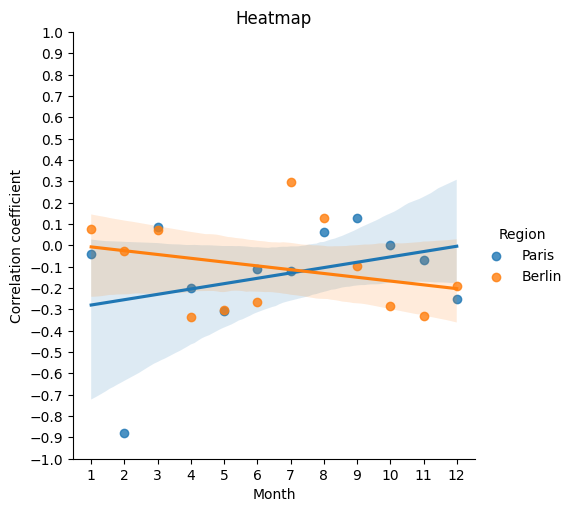

In [16]:
# Visualize: heatmap with x-axis: Month and y-axis: correlation coefficient
# Creates a heatmap of the correlation coefficients over the months of the year in different regions
def visualization_question_one():
    # Create a DataFrame
    df = pd.DataFrame(output_without_threshold, columns=['Month', 'Region', 'Correlation coefficient', 'Threshold'])

    # Drop rows with null values
    df = df.dropna(subset=['Correlation coefficient'])
    df['Month'] = pd.to_numeric(df['Month'])

    # Visualize relationship between total deaths and temperature across all regions
    sns.lmplot(x='Month', y='Correlation coefficient', hue='Region', data=df)
    plt.xticks(range(1, 13))
    plt.yticks(np.arange(-1.0, 1.1, 0.1))

    plt.title('Heatmap')
    plt.show()

visualization_question_one()

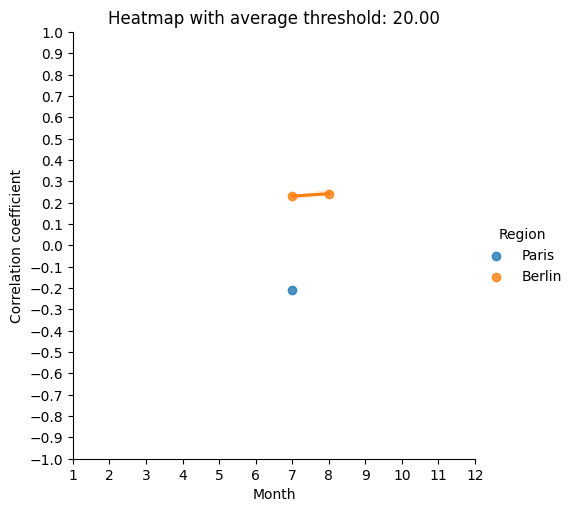

In [21]:
# Visualize: heatmap with x-axis: Month and y-axis: correlation coefficient
# Creates a heatmap of the correlation coefficients over the months of the year in different regions with threshold
def visualization_question_two():
    # Create a DataFrame
    df = pd.DataFrame(output_with_threshold, columns=['Month', 'Region', 'Correlation coefficient', 'Threshold'])

    # Drop rows with null values
    df = df.dropna(subset=['Correlation coefficient'])
    df['Month'] = pd.to_numeric(df['Month'])
    avg_threshold = df['Threshold'].mean()

    # Visualize relationship between total deaths and temperature across all regions
    sns.lmplot(x='Month', y='Correlation coefficient', hue='Region', data=df)
    plt.xticks(range(1, 13))
    plt.yticks(np.arange(-1.0, 1.1, 0.1))

    plt.title(f'Heatmap with average threshold: {avg_threshold:.2f}')
    plt.show()
    
visualization_question_two()